#### Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bamboolib as bam
import seaborn as sns
import plotly.express as px


#### Load dataset

In [3]:
df = pd.read_csv(r"house_price.csv")

#### Explore the data

In [3]:
df.head()

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
df.describe()

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ..

In [4]:
df.isnull().sum().sort_values(ascending=False)

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
FireplaceQu     690
               ... 
ExterQual         0
Exterior2nd       0
Exterior1st       0
RoofMatl          0
SalePrice         0
Length: 81, dtype: int64

#### Pandas profiling - optional

In [ ]:
# import pandas_profiling 

# profile = droppedDf.profile_report(title='Pandas Profiling Report')
# profile.to_file(output_file="Data_Profiling_v3.html")

#### EDA for categorical and numerical features

In [6]:
col_list=df.columns.tolist()

In [7]:
#Make lists for categorical and numerical data
cat_cols=[]
num_cols=[]
for i in col_list:
    if df[i].dtype == "object":
        cat_cols.append(i)
    elif df[i].dtype == "int64" or df[i].dtype == "float64":
        num_cols.append(i)


In [8]:
def plotHistogram(var):
    plt.figure()
    plt.hist(df[var],bins=100,color="orange")
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.title("Frequency - {}".format(var))
    plt.show()

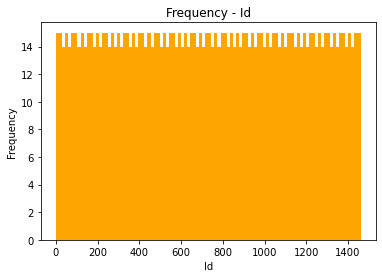

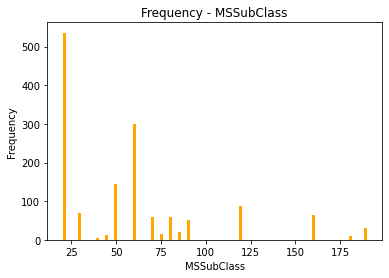

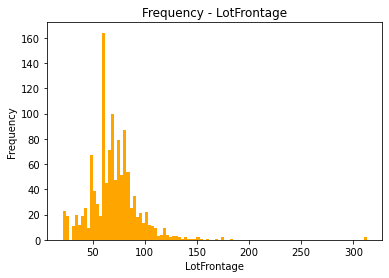

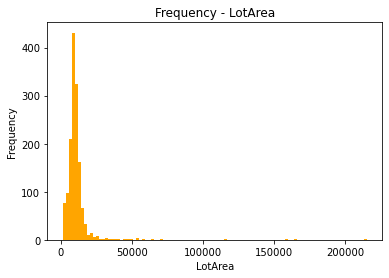

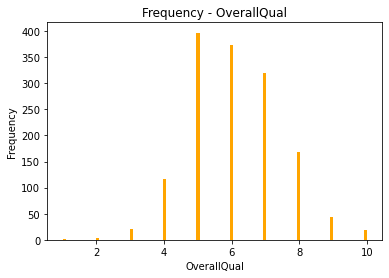

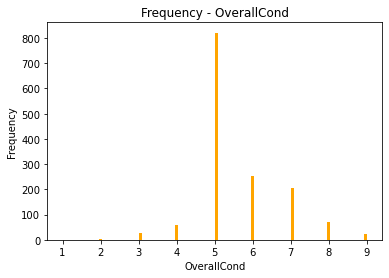

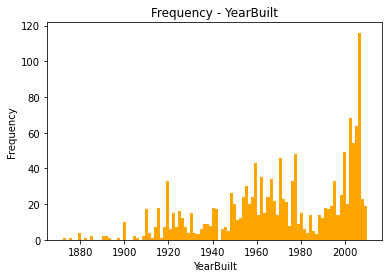

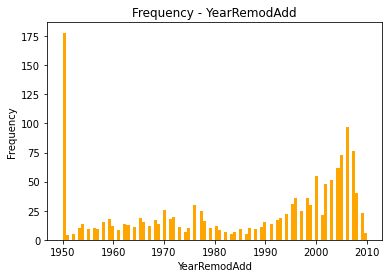

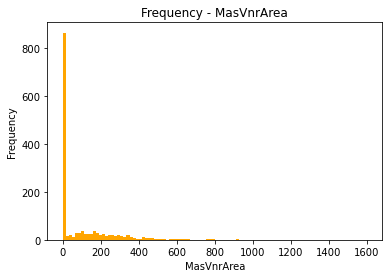

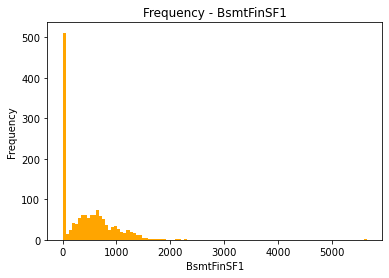

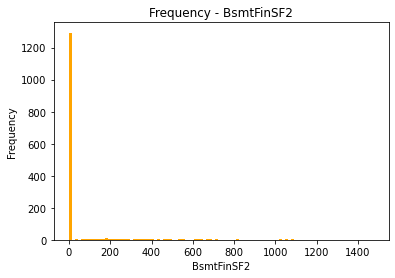

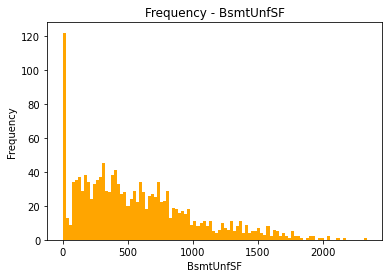

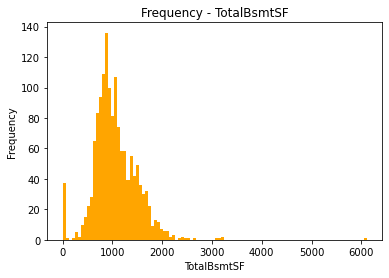

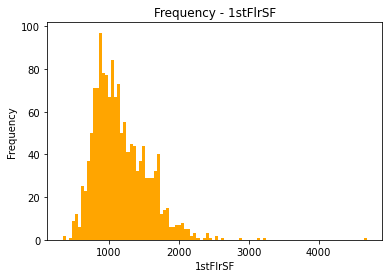

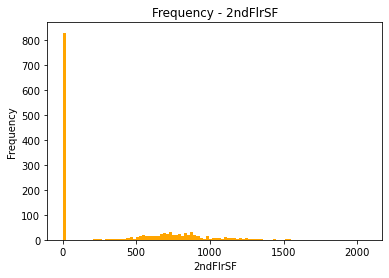

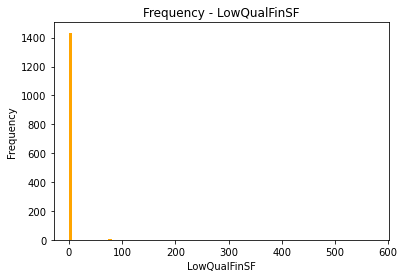

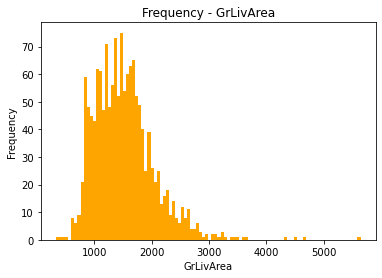

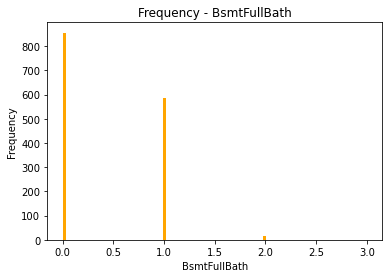

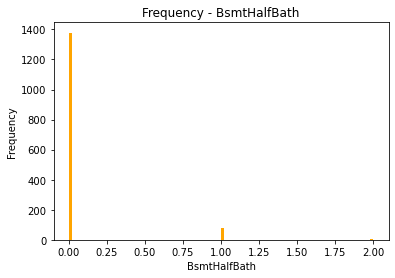

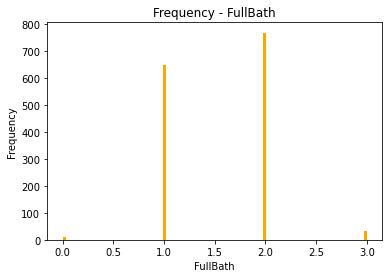

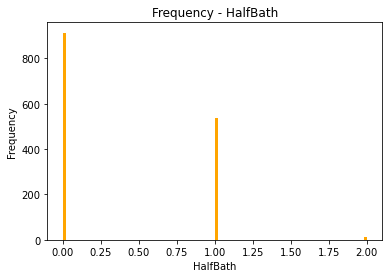

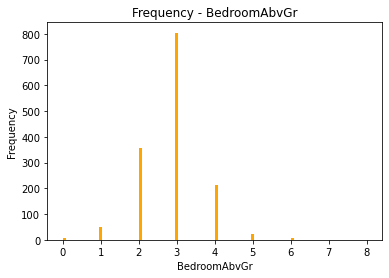

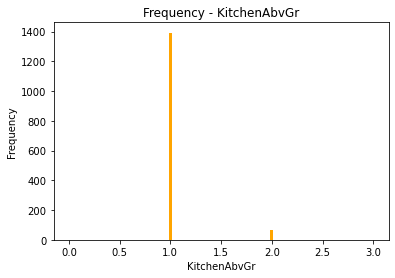

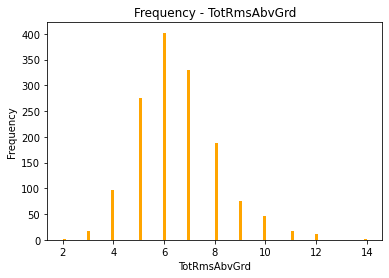

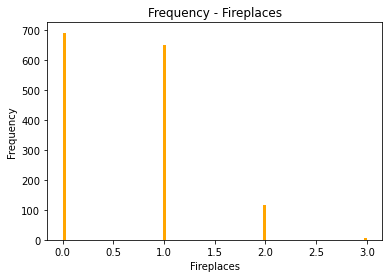

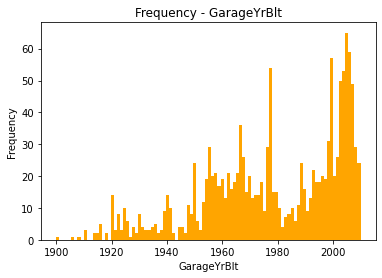

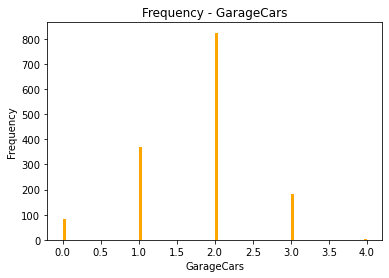

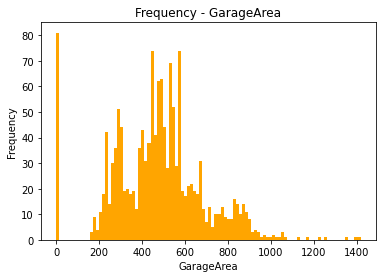

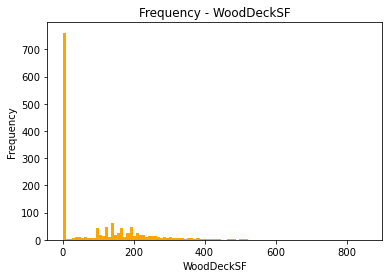

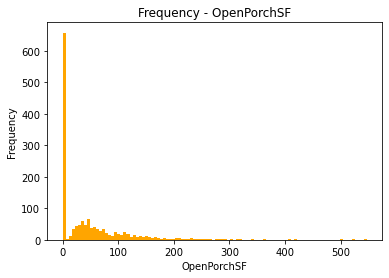

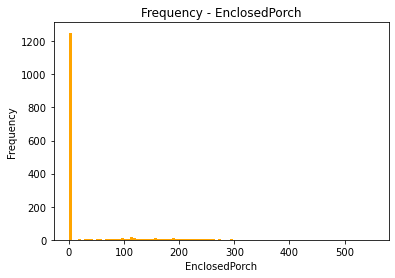

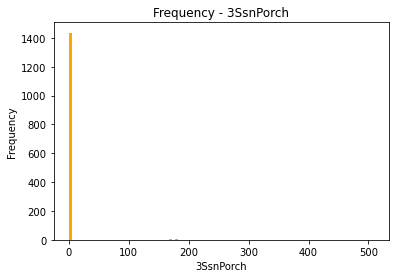

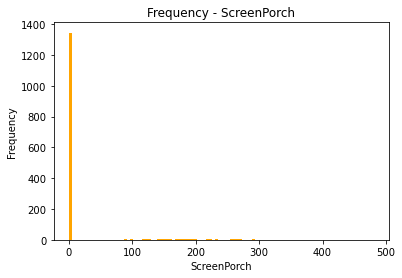

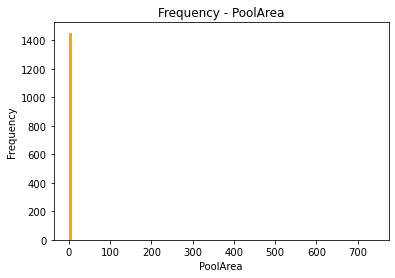

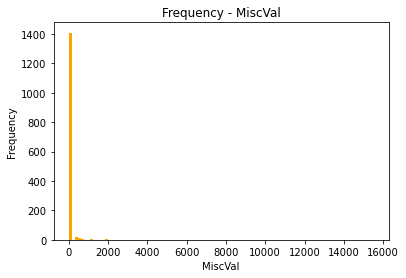

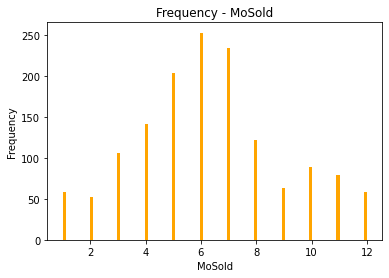

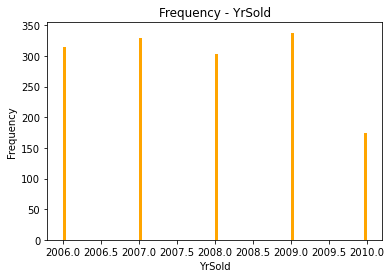

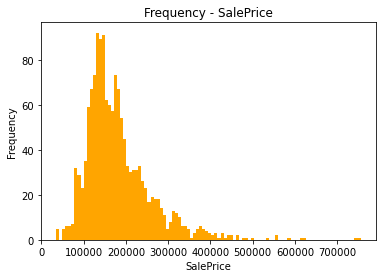

In [9]:
#Show the histogram for every numeric features
for i in num_cols:
    plotHistogram(i)

In [11]:
def plotBar(var,n=5):
    df_=df[var]
    df_count=df_.value_counts()
    df_count=df_count[:n]
    plt.figure()
    plt.bar(df_count.index,df_count,color="blue")
    plt.xticks(df_count.index,df_count.index.values)
    plt.xticks(rotation=45)
    plt.ylabel("Frequency")
    plt.title("Frequency - {}".format(var))
    plt.show()
    print("{}: \n {}".format(var,df_count))

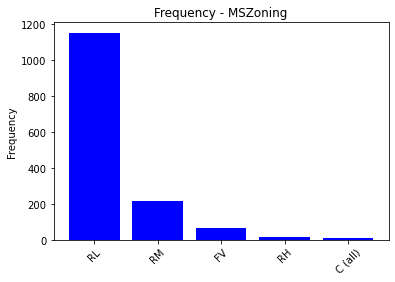

MSZoning: 
 RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64


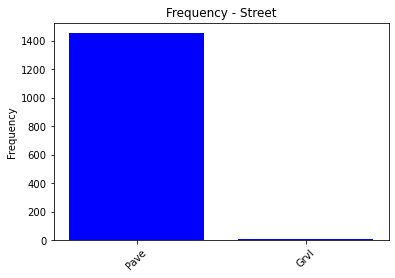

Street: 
 Pave    1454
Grvl       6
Name: Street, dtype: int64


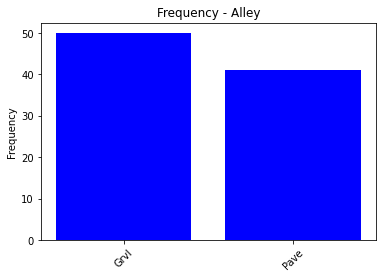

Alley: 
 Grvl    50
Pave    41
Name: Alley, dtype: int64


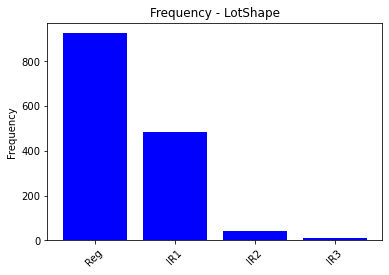

LotShape: 
 Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64


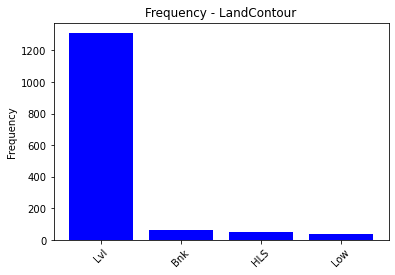

LandContour: 
 Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64


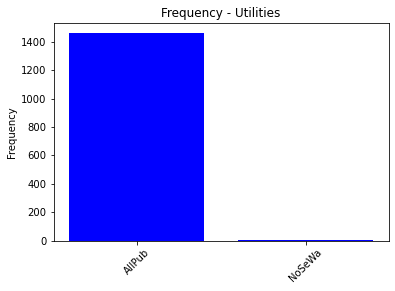

Utilities: 
 AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


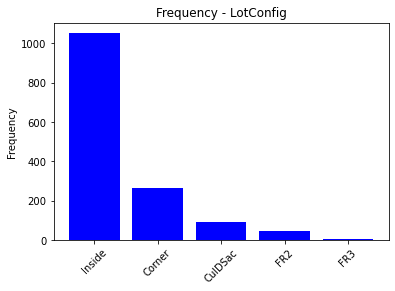

LotConfig: 
 Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64


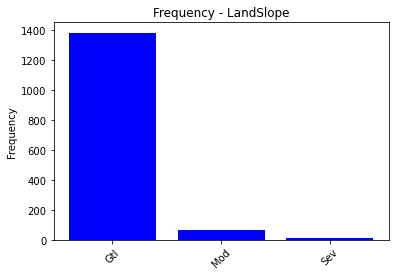

LandSlope: 
 Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64


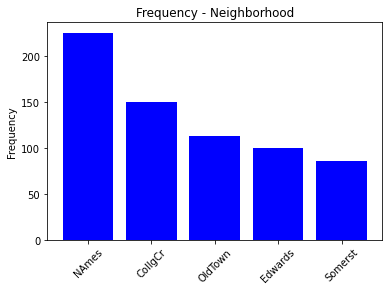

Neighborhood: 
 NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Name: Neighborhood, dtype: int64


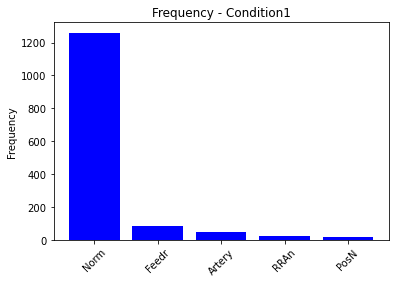

Condition1: 
 Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
Name: Condition1, dtype: int64


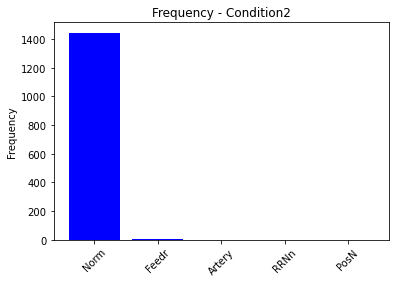

Condition2: 
 Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
Name: Condition2, dtype: int64


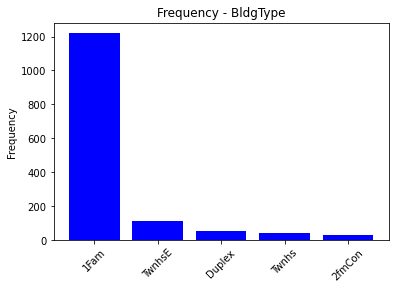

BldgType: 
 1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64


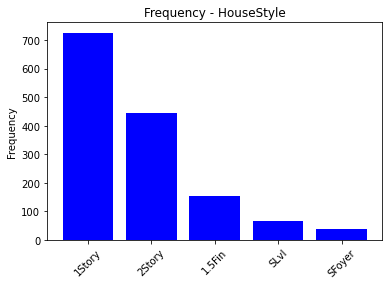

HouseStyle: 
 1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
Name: HouseStyle, dtype: int64


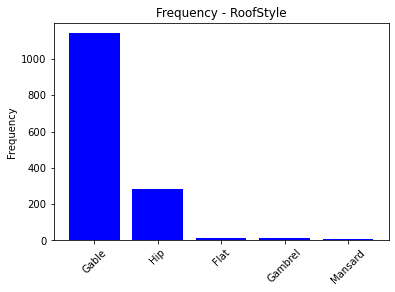

RoofStyle: 
 Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Name: RoofStyle, dtype: int64


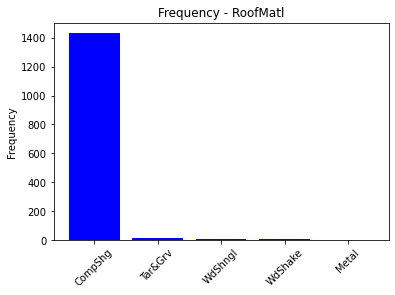

RoofMatl: 
 CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Name: RoofMatl, dtype: int64


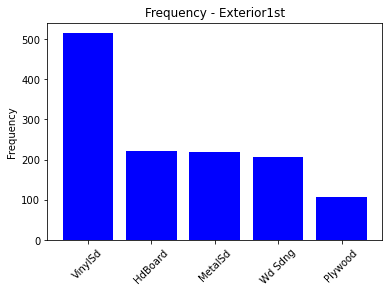

Exterior1st: 
 VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
Name: Exterior1st, dtype: int64


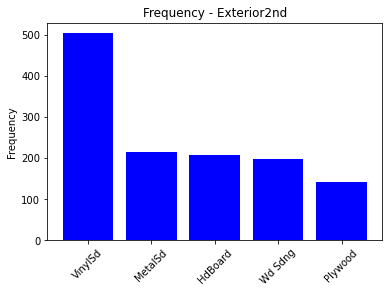

Exterior2nd: 
 VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
Name: Exterior2nd, dtype: int64


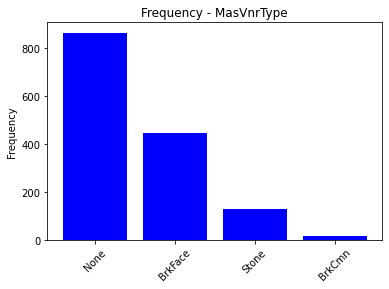

MasVnrType: 
 None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64


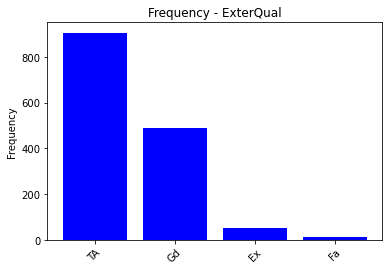

ExterQual: 
 TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64


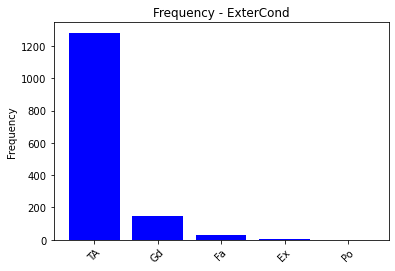

ExterCond: 
 TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64


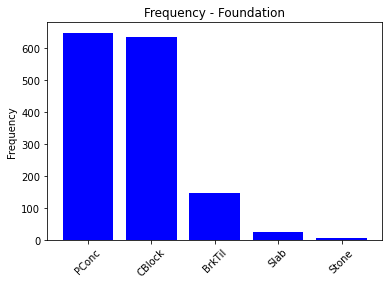

Foundation: 
 PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Name: Foundation, dtype: int64


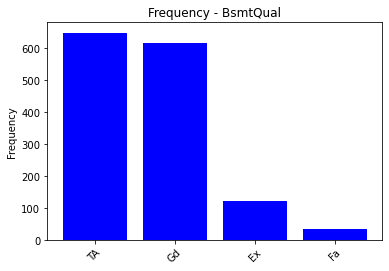

BsmtQual: 
 TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64


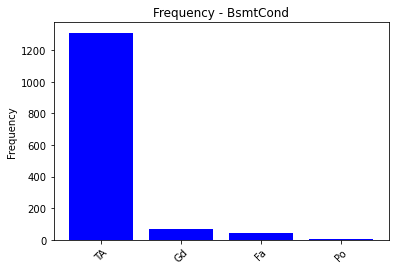

BsmtCond: 
 TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64


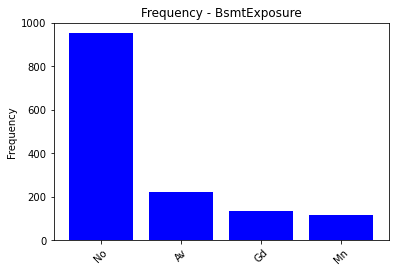

BsmtExposure: 
 No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64


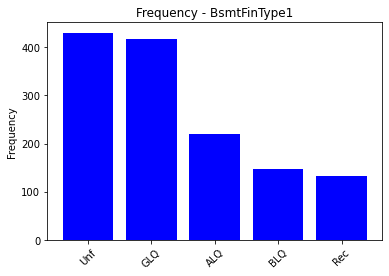

BsmtFinType1: 
 Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
Name: BsmtFinType1, dtype: int64


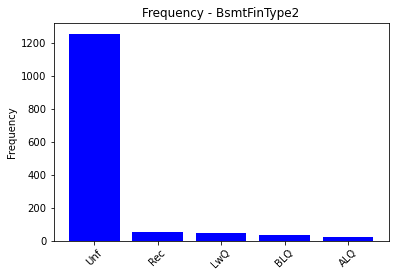

BsmtFinType2: 
 Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
Name: BsmtFinType2, dtype: int64


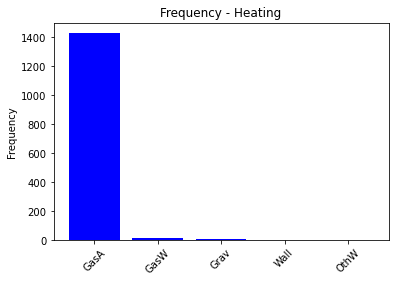

Heating: 
 GasA    1428
GasW      18
Grav       7
Wall       4
OthW       2
Name: Heating, dtype: int64


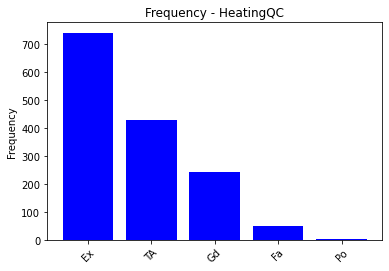

HeatingQC: 
 Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64


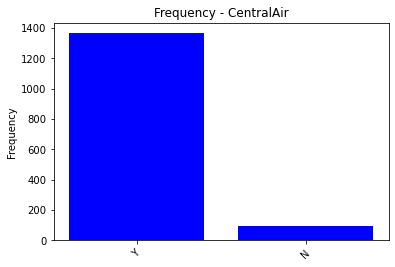

CentralAir: 
 Y    1365
N      95
Name: CentralAir, dtype: int64


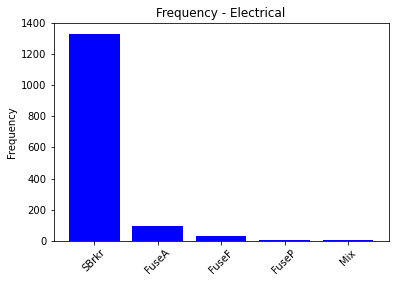

Electrical: 
 SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64


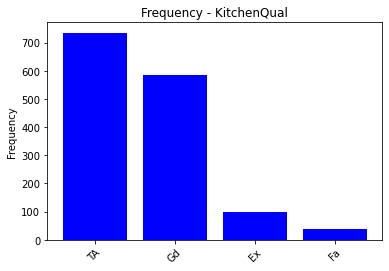

KitchenQual: 
 TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64


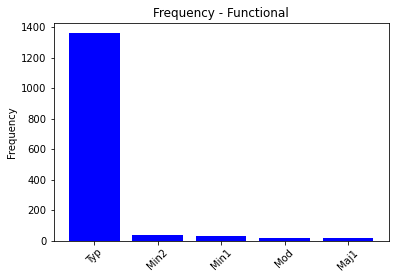

Functional: 
 Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Name: Functional, dtype: int64


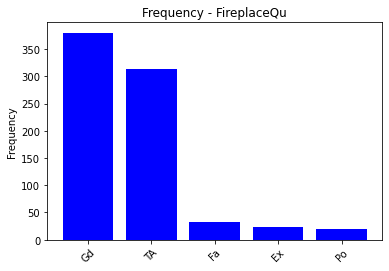

FireplaceQu: 
 Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64


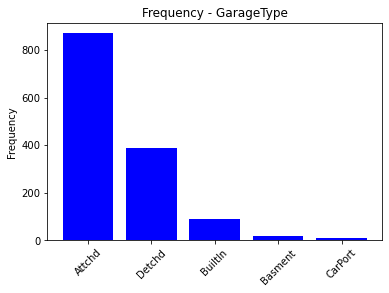

GarageType: 
 Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
Name: GarageType, dtype: int64


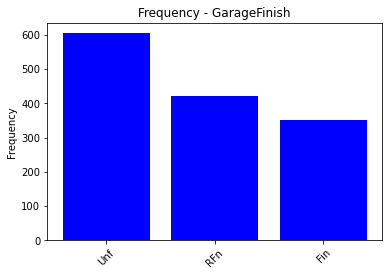

GarageFinish: 
 Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64


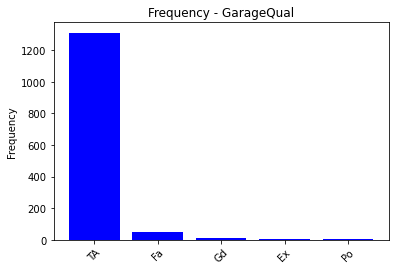

GarageQual: 
 TA    1311
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64


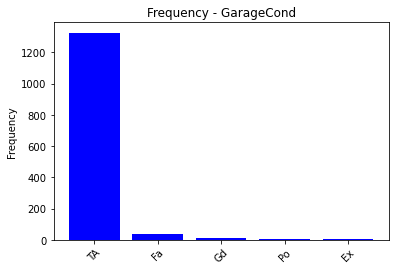

GarageCond: 
 TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64


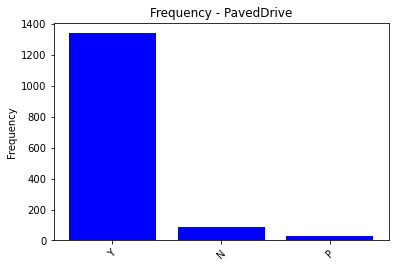

PavedDrive: 
 Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64


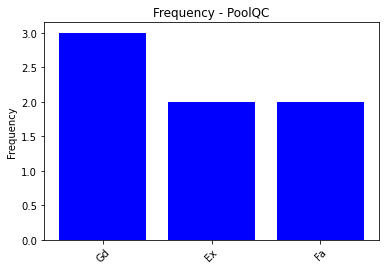

PoolQC: 
 Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64


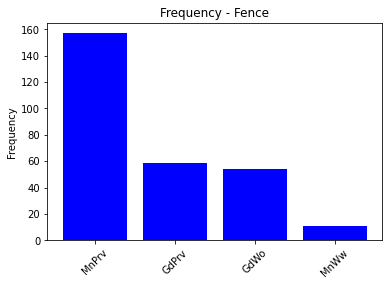

Fence: 
 MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64


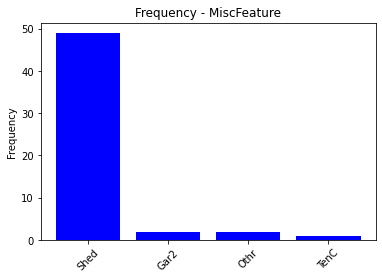

MiscFeature: 
 Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64


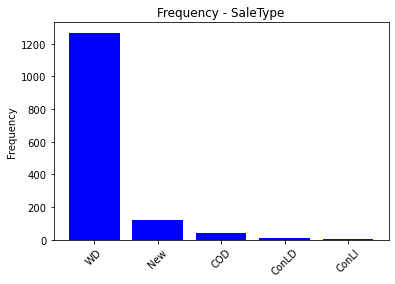

SaleType: 
 WD       1267
New       122
COD        43
ConLD       9
ConLI       5
Name: SaleType, dtype: int64


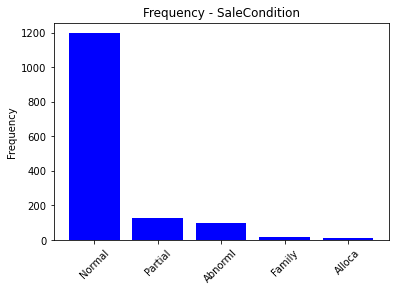

SaleCondition: 
 Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
Name: SaleCondition, dtype: int64


In [12]:
for i in cat_cols:
    plotBar(i)

#### Clean the data

In [51]:
dropColumns = ["Id", "MSSubClass", "MSZoning", "Street", "LandContour", "Utilities", "LandSlope", "Condition1", "Condition2", "BldgType", "OverallCond", "RoofStyle", 
               "RoofMatl", "Exterior1st", "Exterior2nd","MasVnrType", "ExterCond", "Foundation", "BsmtCond", "BsmtExposure", "BsmtFinType1",
              "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF", "Heating", "Electrical", "LowQualFinSF", "BsmtFullBath", "BsmtHalfBath", "HalfBath"] + ["SaleCondition", "SaleType", "YrSold", "MoSold", "MiscVal", "MiscFeature", "Fence", "PoolQC", "PoolArea", "ScreenPorch", "3SsnPorch", "EnclosedPorch", "OpenPorchSF", "WoodDeckSF", "PavedDrive", "GarageCond", "GarageQual", "GarageType", "FireplaceQu", "Functional", "KitchenAbvGr", "BedroomAbvGr"]

droppedDf = df.drop(columns=dropColumns, axis=1)
# droppedDf.head()

In [53]:
droppedDf.isnull().sum().sort_values(ascending=False)

Alley           1369
LotFrontage      259
GarageFinish      81
GarageYrBlt       81
BsmtQual          37
MasVnrArea         8
CentralAir         0
GarageArea         0
GarageCars         0
Fireplaces         0
TotRmsAbvGrd       0
KitchenQual        0
FullBath           0
GrLivArea          0
2ndFlrSF           0
1stFlrSF           0
TotalBsmtSF        0
HeatingQC          0
LotArea            0
BsmtFinSF1         0
ExterQual          0
YearRemodAdd       0
YearBuilt          0
OverallQual        0
HouseStyle         0
Neighborhood       0
LotConfig          0
LotShape           0
SalePrice          0
dtype: int64

#### Impute missing values

In [54]:
droppedDf["Alley"].isna().sum()

1369

In [55]:
droppedDf["Alley"].fillna("NO", inplace=True)

In [56]:
droppedDf["LotFrontage"].fillna(df.LotFrontage.mean(), inplace=True)
# droppedDf["LotFrontage"]


In [57]:
droppedDf["GarageFinish"].fillna("NO", inplace=True)

In [58]:
droppedDf["GarageYrBlt"].fillna(df.GarageYrBlt.mean(), inplace=True)
# droppedDf["GarageYrBlt"]

In [59]:
droppedDf["BsmtQual"].fillna("NO", inplace=True)
# droppedDf["BsmtQual"]

In [60]:
droppedDf["MasVnrArea"].fillna(0, inplace=True)
# droppedDf["MasVnrArea"]

In [61]:
droppedDf['MasVnrAreaCatg'] = np.where(droppedDf.MasVnrArea>1000,'BIG',
                                      np.where(droppedDf.MasVnrArea>500,'MEDIUM',
                                              np.where(droppedDf.MasVnrArea>0,'SMALL','NO')))

In [ ]:
droppedDf.info()

In [62]:
inputDf = droppedDf.drop(['SalePrice'],axis=1)
inputDf = inputDf.iloc[[0]].copy()

In [72]:
for i in inputDf:
    if inputDf[i].dtype == "object":
        inputDf[i] = droppedDf[i].mode()[0]
    elif inputDf[i].dtype == "int64" or inputDf[i].dtype == "float64":
        inputDf[i] = droppedDf[i].mean()
inputDf

obj_feat = list(inputDf.loc[:, inputDf.dtypes == 'object'].columns.values)
for feature in obj_feat:
    inputDf[feature] = inputDf[feature].astype('category')

## Modeling

### Importing the libraries

In [64]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [65]:
df = droppedDf.copy()

In [66]:
obj_feat = list(df.loc[:, df.dtypes == 'object'].columns.values)
for feature in obj_feat:
    df[feature] = df[feature].astype('category')

In [67]:
# To define the input and output feature
x = df.drop(['SalePrice'],axis=1)
y = df.SalePrice

# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.30,random_state=1)
x.iloc[0].index

Index(['LotFrontage', 'LotArea', 'Alley', 'LotShape', 'LotConfig',
       'Neighborhood', 'HouseStyle', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'BsmtQual', 'BsmtFinSF1',
       'TotalBsmtSF', 'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'FullBath', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'MasVnrAreaCatg'],
      dtype='object')

In [68]:
model = lgb.LGBMRegressor(max_depth=5, 
                          n_estimators = 100, 
                          learning_rate = 0.2,
                          min_child_samples = 30)
model.fit(x_train, y_train)

pred_y_train = model.predict(x_train)
pred_y_test = model.predict(x_test)

r2_train = metrics.r2_score(y_train, pred_y_train)
r2_test = metrics.r2_score(y_test, pred_y_test)

msle_train =metrics.mean_squared_log_error(y_train, pred_y_train)
msle_test =metrics.mean_squared_log_error(y_test, pred_y_test)

print(f"Train r2 = {r2_train:.2f} \nTest r2 = {r2_test:.2f}")
print(f"Train msle = {msle_train:.2f} \nTest msle = {msle_test:.2f}")

Train r2 = 0.97 
Test r2 = 0.91
Train msle = 0.01 
Test msle = 0.02


In [69]:
from sklearn.model_selection import GridSearchCV

params = [{"max_depth":[3, 5], 
            "n_estimators" : [50, 100], 
            "learning_rate" : [0.1, 0.2],
            "min_child_samples" : [20, 10]}]

gs_knn = GridSearchCV(model,
                      param_grid=params,
                      cv=5)

gs_knn.fit(x_train, y_train)
gs_knn.score(x_train, y_train)

pred_y_train = model.predict(x_train)
pred_y_test = model.predict(x_test)

r2_train = metrics.r2_score(y_train, pred_y_train)
r2_test = metrics.r2_score(y_test, pred_y_test)

msle_train =metrics.mean_squared_log_error(y_train, pred_y_train)
msle_test =metrics.mean_squared_log_error(y_test, pred_y_test)

print(f"Train r2 = {r2_train:.2f} \nTest r2 = {r2_test:.2f}")
print(f"Train msle = {msle_train:.2f} \nTest msle = {msle_test:.2f}")

gs_knn.best_params_


Train r2 = 0.97 
Test r2 = 0.91
Train msle = 0.01 
Test msle = 0.02


{'learning_rate': 0.2,
 'max_depth': 3,
 'min_child_samples': 10,
 'n_estimators': 100}

In [70]:
# save the model to disk
import pickle

filename = 'finalized_model.model'
pickle.dump(model, open(filename, 'wb'))

In [73]:
# Load the model from disk
import pickle

filename = 'finalized_model.model'

loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)

# predict
print(loaded_model.predict(inputDf))


0.9065596642357174
[159120.15487566]
